In [1]:
import numpy as np
import pandas as pd

from numpy import genfromtxt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
import lightgbm as lgb
from sklearn.metrics.pairwise import nan_euclidean_distances
from sklearn import tree
from sklearn.svm import SVC
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.mplot3d import Axes3D


from sklearn.decomposition import PCA
from base64 import encode
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn import compose
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import mean_absolute_error

import copy


from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax import optimize
from ax.utils.notebook.plotting import render, init_notebook_plotting
%matplotlib inline

rng = 0

test_values = pd.read_csv("./test-set-values.csv")
train_values = pd.read_csv("./training-set-values.csv")
train_labels = pd.read_csv("./training-set-labels.csv")


from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score,\
 confusion_matrix, roc_auc_score, roc_curve

from sklearn.preprocessing import  label_binarize




/home/ryan/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("columns:")
print(train_values.columns.values)
print()
print(train_values.info())

columns:
['id' 'amount_tsh' 'date_recorded' 'funder' 'gps_height' 'installer'
 'longitude' 'latitude' 'wpt_name' 'num_private' 'basin' 'subvillage'
 'region' 'region_code' 'district_code' 'lga' 'ward' 'population'
 'public_meeting' 'recorded_by' 'scheme_management' 'scheme_name' 'permit'
 'construction_year' 'extraction_type' 'extraction_type_group'
 'extraction_type_class' 'management' 'management_group' 'payment'
 'payment_type' 'water_quality' 'quality_group' 'quantity'
 'quantity_group' 'source' 'source_type' 'source_class' 'waterpoint_type'
 'waterpoint_type_group']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 


In [3]:
train_values.dtypes[lambda x: x == 'object']

date_recorded            object
funder                   object
installer                object
wpt_name                 object
basin                    object
subvillage               object
region                   object
lga                      object
ward                     object
public_meeting           object
recorded_by              object
scheme_management        object
scheme_name              object
permit                   object
extraction_type          object
extraction_type_group    object
extraction_type_class    object
management               object
management_group         object
payment                  object
payment_type             object
water_quality            object
quality_group            object
quantity                 object
quantity_group           object
source                   object
source_type              object
source_class             object
waterpoint_type          object
waterpoint_type_group    object
dtype: object

In [4]:
train_values.iloc[:, :20].describe(include='all')

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by
count,59400.000000,59400.000000,59400,55765,59400.000000,55745,59400.000000,5.940000e+04,59400,59400.000000,59400,59029,59400,59400.000000,59400.000000,59400,59400,59400.000000,56066,59400
unique,NaN,NaN,356,1897,NaN,2145,NaN,NaN,37400,NaN,9,19287,21,NaN,NaN,125,2092,NaN,2,1
top,NaN,NaN,2011-03-15,Government Of Tanzania,NaN,DWE,NaN,NaN,none,NaN,Lake Victoria,Madukani,Iringa,NaN,NaN,Njombe,Igosi,NaN,True,GeoData Consultants Ltd
freq,NaN,NaN,572,9084,NaN,17402,NaN,NaN,3563,NaN,10248,508,5294,NaN,NaN,2503,307,NaN,51011,59400
mean,37115.131768,317.650385,NaN,NaN,668.297239,NaN,34.077427,-5.706033e+00,NaN,0.474141,NaN,NaN,NaN,15.297003,5.629747,NaN,NaN,179.909983,NaN,NaN
std,21453.128371,2997.574558,NaN,NaN,693.116350,NaN,6.567432,2.946019e+00,NaN,12.236230,NaN,NaN,NaN,17.587406,9.633649,NaN,NaN,471.482176,NaN,NaN
min,0.000000,0.000000,NaN,NaN,-90.000000,NaN,0.000000,-1.164944e+01,NaN,0.000000,NaN,NaN,NaN,1.000000,0.000000,NaN,NaN,0.000000,NaN,NaN
25%,18519.750000,0.000000,NaN,NaN,0.000000,NaN,33.090347,-8.540621e+00,NaN,0.000000,NaN,NaN,NaN,5.000000,2.000000,NaN,NaN,0.000000,NaN,NaN
50%,37061.500000,0.000000,NaN,NaN,369.000000,NaN,34.908743,-5.021597e+00,NaN,0.000000,NaN,NaN,NaN,12.000000,3.000000,NaN,NaN,25.000000,NaN,NaN
75%,55656.500000,20.000000,NaN,NaN,1319.250000,NaN,37.178387,-3.326156e+00,NaN,0.000000,NaN,NaN,NaN,17.000000,5.000000,NaN,NaN,215.000000,NaN,NaN


In [5]:
train_values.iloc[:, 21:].describe(include='all')

,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,31234,56344,59400.000000,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,2696,2,NaN,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6
top,K,True,NaN,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
freq,682,38852,NaN,26780,26780,26780,40507,52490,25348,25348,50818,50818,33186,33186,17021,17021,45794,28522,34625
mean,NaN,NaN,1300.652475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,951.620547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,1986.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,2004.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            59400 non-null  int64 
 1   status_group  59400 non-null  object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


In [7]:
d = {
    "funder": "string",
    "installer": "string",
    "wpt_name": "string",
    "basin": "string",
    "subvillage": "string",
    "region": "string",
    "lga": "string",
    "ward": "string",
    "public_meeting": "string",
    "recorded_by": "string",
    "scheme_management": "string",
    "scheme_name": "string",
    "permit": "string",
    "extraction_type": "string",
    "extraction_type_group": "string",
    "extraction_type_class": "string",
    "management": "string",
    "management_group": "string",
    "payment": "string",
    "payment_type": "string",
    "water_quality": "string",
    "quality_group": "string",
    "quantity": "string",
    "quantity_group": "string",
    "source": "string",
    "source_type": "string",
    "source_class": "string",
    "waterpoint_type": "string",
    "waterpoint_type_group": "string",
    "date_recorded":"string",
}
train_values= train_values.astype(d)
# train_values["date_recorded"] = pd.to_datetime(
#     train_values["date_recorded"],
#     infer_datetime_format=True
# )

train_labels.status_group = train_labels.status_group.astype('string')
train = train_values.merge(train_labels, on="id")
train_labels.drop('id',inplace=True,axis=True)

# Null and Nan checking

In [ ]:
# print("any nulls in train_values?")
# print(pd.isnull(train_values).any()[lambda x: x == True])
# print()
print("any NANs in train_values?")
print(pd.isna(train_values).any()[lambda x:x == True])


There are alot of "0" strings around the features, they will be imputed to be "Unknown" just like the Nans.

# Checking correlations between numerical features

# Showing Values:

In [ ]:
train_values.iloc[:, :20].head()

In [ ]:
train_values.iloc[:, 21:40].head()

In [ ]:
numerical_variables = [
    "amount_tsh",
    "gps_height",
    "longitude",
    "latitude",
    "region_code",
    "district_code",
    "population",
    "construction_year",
]
# print(train.columns)
# sns.pairplot(train.sample(1000),kind="scatter")
# commented out the previous line because running all with this line is very slow

sns.heatmap(data=train_values.corr(),vmin=-1, vmax=1, annot=True)

In [ ]:
sns.pairplot(train,hue='status_group',kind='scatter')

There is not much useful correlations inbetween the numerical features

Including population and amount of tsh

# Location based status groups


In [ ]:
f, ax = plt.subplots(figsize=(10, 10))
sns.despine(f, left=True, bottom=True)
plt.xlim(27,43)
# plt.figure(figsize=(400,400))
m = Basemap(resolution='i',llcrnrlat=-12.168,urcrnrlat=-0.967,llcrnrlon=28.828,urcrnrlon=41.177)
# draw coastlines.
m.drawcoastlines()
# draw a boundary around the map, fill the background.
# this background will end up being the ocean color, since
# the continents will be drawn on top.
m.drawmapboundary(fill_color='aqua')
m.drawcountries()
# fill continents, set lake color same as ocean color.
m.fillcontinents(color='coral',lake_color='aqua')
# m.bluemarble()
for index, row in train.iterrows():
    if row.status_group == "functional":
        markercolor="green"
    elif row.status_group == "functional need repair":
        markercolor = "white"
    else:
        markercolor = "black"
    m.plot(row.longitude,
    row.latitude,
    marker="*",
    markersize=4,
    markeredgewidth=0,
    markeredgecolor="white",
    markerfacecolor=markercolor
    )
plt.show()

#                 data=train, ax=ax, hue = "status_group", style="status_group",s=5)


Elevation heatmap:

![screenshot](./screenshot.png)

In [ ]:
sns.histplot(train,x='status_group')


more functional pumps than  sub-functional pumps but not by much

In [ ]:
temp = train[train.construction_year != 0]
sns.catplot(kind= 'box',data = temp, y='status_group',x='construction_year',tit)

more sub-functional pumps for in their respective 25% and 50% percentiles
than the funtional pumps.

In [ ]:
sns.catplot(data = train, x = 'gps_height',y = 'status_group',kind='box',ax=ax[1])


'height' has a bit of correlation to 'status_group'? Higher = more functional? But correlation isn't causation.

In [ ]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
ax.set_xlim((0,1000))
sns.boxplot(data = train, x = 'population',y = 'status_group' ,ax=ax)

population does seem to have a bit of correlations to pumps that are sub-functional.

# Creation and comparison of Estimators

In [8]:

cat_vars = [
    'funder', 'installer', "date_recorded",
    'wpt_name', 'num_private', 'basin',
    'subvillage', 'region',  'lga',
    'ward', 'public_meeting', 'recorded_by',
    'scheme_management', 'scheme_name', 'extraction_type', 'extraction_type_group',
    'extraction_type_class', 'management', 'management_group', 'payment',
    'payment_type', 'water_quality', 'quality_group', 'quantity',
    'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', "waterpoint_type_group"]

# -1 instead of np.nan works for me
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
scaler = StandardScaler()
pca = PCA(random_state=0)
gbc = GradientBoostingClassifier()
svc = SVC()
dtc = tree.DecisionTreeClassifier()

train_values.fillna(value="Unknown", inplace=True)
print(pd.isna(train_values).any()[lambda x: x == True])


Series([], dtype: bool)


Initial fitting and transformation to find the best number of principal components

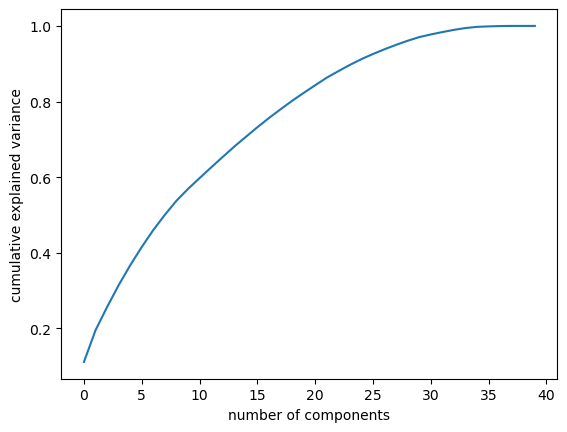

In [11]:
encoded_train_values = encoder.fit_transform(train_values)
scaled_train_values = scaler.fit_transform(encoded_train_values,y=train_labels)
pca.fit(scaled_train_values)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

15 component for ~80% of the variance is good enough.

In [ ]:
# pca = PCA(n_components=15)

KFold for extracting train and test holdouts. and y text labels are label binarize

In [9]:
kfold = KFold(5)
fold_indices = []
for rest, pick in kfold.split(train_values):
    fold_indices.append(pick)

trainIndices = fold_indices[0]
np.append(trainIndices, fold_indices[1])
np.append(trainIndices, fold_indices[2])
np.append(trainIndices, fold_indices[3])
testIndices = fold_indices[4]

x_train = train_values.iloc[trainIndices,:]
y_train = train_labels.iloc[trainIndices,:]
x_test = train_values.iloc[testIndices,:]
y_test = train_labels.iloc[testIndices,:]

y_test_binarized = label_binarize(y_train,classes=y_train.iloc[:,0].unique())

In [18]:
y_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11880 entries, 47520 to 59399
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   status_group  11880 non-null  string
dtypes: string(1)
memory usage: 185.6 KB


## Estimator 1: Gradient Boosting classifier

x


/home/ryan/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



y
z


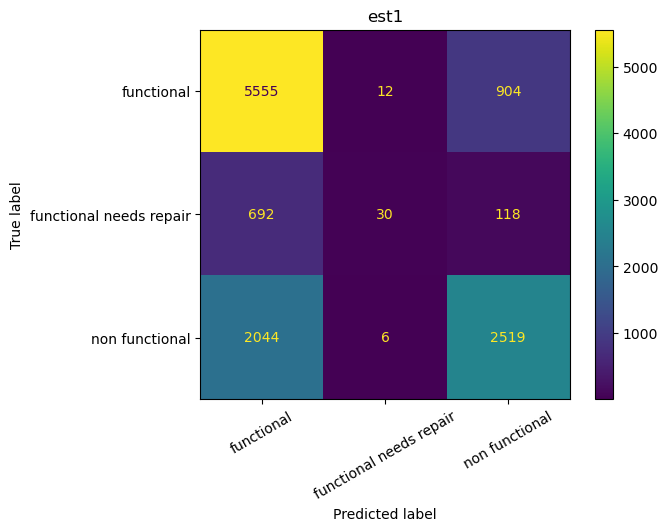

                         precision    recall  f1-score   support

             functional       0.54      0.69      0.61      6431
functional needs repair       0.04      0.00      0.00       861
         non functional       0.39      0.30      0.34      4588

               accuracy                           0.49     11880
              macro avg       0.32      0.33      0.32     11880
           weighted avg       0.44      0.49      0.46     11880

AUROC score: 0.48662596693895427


In [24]:
est1 = Pipeline(steps=[
        ('encoder',OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
        ('scaler',StandardScaler()),
        ('principal_component_analysis',PCA(n_components=15,random_state=rng)),
        ('gradient_boosting_classifier',GradientBoostingClassifier(
    
        ))
    ])
print("x")
pipeline_1 = est1.fit(x_train,y=y_train)
print("y")

y_predictions_1 = pipeline_1.predict(x_test)
print("z")



y_probabilities_1 = pipeline_1.predict_proba(x_test)
cm = confusion_matrix(y_test,y_predictions_1)
display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=est1.classes_)
display.plot()
plt.xticks(rotation = 30)
plt.title("est1")
plt.show()

print(classification_report(y_train, y_predictions_1))
print("AUROC score:",roc_auc_score(y_test_binarized, y_probabilities_1,multi_class='ovr',labels=[0,1,2]))

In [33]:
def train_predict_est_1(parameters, x_train,y_train,x_test,show_stats=False):
    est = Pipeline(steps=[
        ('encoder',OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
        ('scaler',StandardScaler()),
        ('principal_component_analysis',PCA(n_components=15,random_state=rng)),
        ('gradient_boosting_classifier',GradientBoostingClassifier(
            learning_rate=parameters['gbr_learning_rate'],
            n_estimators= parameters['gbr_n_estimators']
        ))
    ])
    pipeline = est.fit(x_train,y=y_train)
    y_predictions = pipeline.predict(x_test)

    
    if not show_stats:
        return y_predictions
    y_probabilities = pipeline.predict_proba(x_test)
    cm = confusion_matrix(y_test,y_predictions)
    display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=est1.classes_)
    display.plot()
    plt.xticks(rotation = 30)
    plt.title("est1")
    plt.show()

    print(classification_report(y_train, y_predictions))
    print("AUROC score:",roc_auc_score(y_test_binarized, y_probabilities,multi_class='ovr',labels=[0,1,2]))
    return y_predictions
    
parameterScope=[
        {"name":"gbr_learning_rate" ,"type": "choice","value_type":"float", 
         "values": [0.07,0.06,0.05,0.04,0.03,0.02,0.01]},
        {"name":"gbr_n_estimators" ,"type": "range", "bounds": [150,200]},
]

In [29]:
def ax_optimise(parameters):
    predictions = train_predict_est_1(parameters, x_train,y_train.values.ravel(),x_test,show_stats=False)

    return mean_absolute_error(y_test_binarized,
    label_binarize(predictions,classes=['functional','functional needs repair','non functional'])
    )

best_parameters, values, experiment, model = optimize(
    parameters=parameterScope,
    evaluation_function=ax_optimise,
    objective_name='accuracy',
    total_trials=16,
    minimize=True
)

/home/ryan/anaconda3/lib/python3.10/site-packages/ax/core/parameter.py:480: UserWarning:

`is_ordered` is not specified for `ChoiceParameter` "gbr_learning_rate". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `is_ordered` during `ChoiceParameter` construction.

/home/ryan/anaconda3/lib/python3.10/site-packages/ax/core/parameter.py:480: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "gbr_learning_rate". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

[INFO 09-28 10:30:39] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter gbr_n_estimators. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 09-28 10:30:39] ax.service.utils.instantiation: Created sea

## Estimator 2: Decision Tree Classifier

In [ ]:
# est2 = Pipeline(steps=[
#     ('encoder',encoder),
#     ('scaler',scaler),
#     ('principal_component_analysis',pca),
#     ('decision_tree_classifier',dtc)
# ])
# pipeline_2 = est1.fit(x_train,y=y_train)
# y_predictions_2 = pipeline_2.predict(x_test)
# y_probabilities_2 = pipeline_2.predict_proba(x_test)

In [44]:
def train_predict_est_2(parameters, x_train,y_train,x_test,show_stats=False):
    est = Pipeline(steps=[
        ('encoder',OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
        ('scaler',StandardScaler()),
        ('principal_component_analysis',PCA(n_components=15,random_state=rng)),
        ('decision_tree_classifier',tree.DecisionTreeClassifier(
  random_state=rng,
  max_depth=parameters['max_depth'],
  criterion=parameters['criterion']
        ))
    ])
    pipeline = est.fit(x_train,y=y_train)
    y_predictions = pipeline.predict(x_test)

    
    if not show_stats:
        return y_predictions
    y_probabilities = pipeline.predict_proba(x_test)
    cm = confusion_matrix(y_test,y_predictions)
    display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=est.classes_)
    display.plot()
    plt.xticks(rotation = 30)
    plt.title("est2")
    plt.show()

    print(classification_report(y_train, y_predictions))
    print("AUROC score:",roc_auc_score(y_test_binarized, y_probabilities,multi_class='ovr',labels=[0,1,2]))
    return y_predictions
    
parameterScope=[
        {"name":"max_depth" ,"type": "choice","value_type":"int", 
         "values": [1,2,3,4,5,6,7,8,9,10]},
        {"name":"criterion" ,"type": "choice","value_type":"str","values":["gini","entropy","log_loss"]},
]
def ax_optimise(parameters):
    predictions = train_predict_est_2(parameters, x_train,y_train.values.ravel(),x_test,show_stats=False)

    return mean_absolute_error(y_test_binarized,
    label_binarize(predictions,classes=['functional','functional needs repair','non functional'])
    )

best_parameters, values, experiment, model = optimize(
    parameters=parameterScope,
    evaluation_function=ax_optimise,
    objective_name='accuracy',
    total_trials=16,
    minimize=True
)

/home/ryan/anaconda3/lib/python3.10/site-packages/ax/core/parameter.py:480: UserWarning:

`is_ordered` is not specified for `ChoiceParameter` "max_depth". Defaulting to `True` for parameters of `ParameterType` INT. To override this behavior (or avoid this warning), specify `is_ordered` during `ChoiceParameter` construction.

/home/ryan/anaconda3/lib/python3.10/site-packages/ax/core/parameter.py:480: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "max_depth". Defaulting to `True` for parameters of `ParameterType` INT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

/home/ryan/anaconda3/lib/python3.10/site-packages/ax/core/parameter.py:480: UserWarning:

`is_ordered` is not specified for `ChoiceParameter` "criterion". Defaulting to `False` for parameters of `ParameterType` STRING. To override this behavior (or avoid this warning), specify `is_ordered` during `ChoiceParameter` construction.

/home/ryan/an

## Estimator 3: Support Vector Classificer (SVM)

In [ ]:
def train_predict_est_3(parameters, x_train,y_train,x_test,show_stats=False):
    est = Pipeline(steps=[
        ('encoder',OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
        ('scaler',StandardScaler()),
        ('principal_component_analysis',PCA(n_components=15,random_state=rng)),
        ('support_vector_classifier',SVC(
            kernel=parameters['kernel'],
            degree=parameters['degree'],
            cache_size=1000,
        ))
    ])
    pipeline = est.fit(x_train,y=y_train)
    y_predictions = pipeline.predict(x_test)
 
    
    if not show_stats:
        return y_predictions
    y_probabilities = pipeline.predict_proba(x_test)
    cm = confusion_matrix(y_test,y_predictions)
    display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=est.classes_)
    display.plot()
    plt.xticks(rotation = 30)
    plt.title("est2")
    plt.show()

    print(classification_report(y_train, y_predictions))
    print("AUROC score:",roc_auc_score(y_test_binarized, y_probabilities,multi_class='ovr',labels=[0,1,2]))
    return y_predictions
    
parameterScope=[
        {"name":"degree" ,"type": "choice","value_type":"int", 
         "values": [1,2,3,4,5,6,7,8,9,10]},
        {"name":"kernel" ,"type": "choice","value_type":"str","values":["linear","poly","rbf",'sigmoid','precomputed']},
]
def ax_optimise(parameters):
    predictions = train_predict_est_2(parameters, x_train,y_train.values.ravel(),x_test,show_stats=False)

    return mean_absolute_error(y_test_binarized,
    label_binarize(predictions,classes=['functional','functional needs repair','non functional'])
    )

best_parameters, values, experiment, model = optimize(
    parameters=parameterScope,
    evaluation_function=ax_optimise,
    objective_name='accuracy',
    total_trials=16,
    minimize=True
)

In [ ]:
# est3 = Pipeline(steps=[
#     ('encoder',encoder),
#     ('scaler',scaler),
#     ('principal_component_analysis',pca),
#     ('support_vector_classifier',SVC)
# ])
# pipeline_3 = est1.fit(x_train,y=y_train)
# y_predictions_3 = pipeline_3.predict(x_test)
# y_probabilities_3 = pipeline_3.predict_proba(x_test)

## Comparison between estimator pipelines

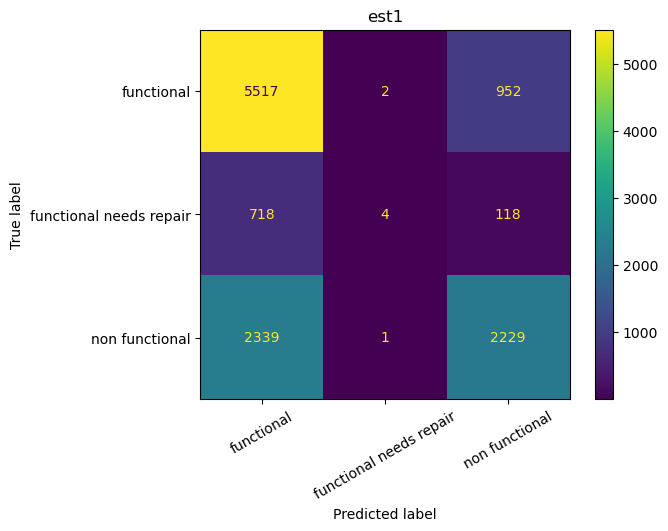

                         precision    recall  f1-score   support

             functional       0.54      0.72      0.61      6431
functional needs repair       0.00      0.00      0.00       861
         non functional       0.38      0.28      0.32      4588

               accuracy                           0.49     11880
              macro avg       0.31      0.33      0.31     11880
           weighted avg       0.44      0.49      0.46     11880

AUROC score: 0.4880133020736713


array(['functional', 'functional', 'functional', ..., 'non functional',
       'functional', 'functional'], dtype=object)

In [34]:
train_predict_est_1(best_parameters, x_train,y_train.values.ravel(),x_test,show_stats=True)

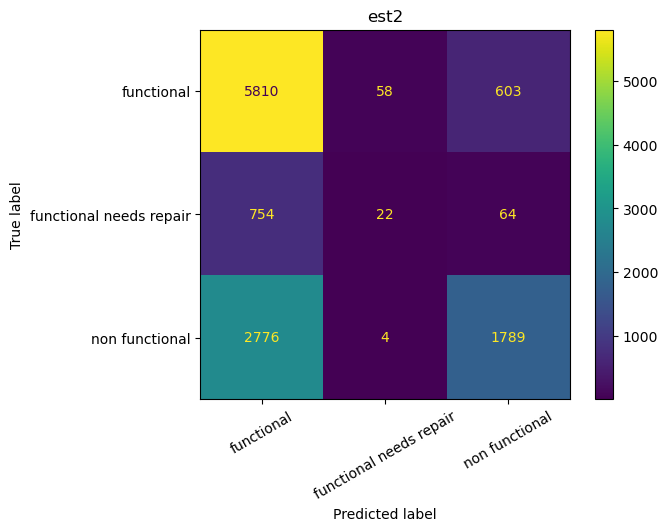

                         precision    recall  f1-score   support

             functional       0.54      0.78      0.64      6431
functional needs repair       0.01      0.00      0.00       861
         non functional       0.38      0.20      0.26      4588

               accuracy                           0.50     11880
              macro avg       0.31      0.33      0.30     11880
           weighted avg       0.44      0.50      0.45     11880

AUROC score: 0.4926182715816732


array(['functional', 'functional', 'functional', ..., 'functional',
       'functional', 'functional'], dtype=object)

In [43]:
train_predict_est_2(best_parameters, x_train,y_train.values.ravel(),x_test,show_stats=True)

In [ ]:
cm = confusion_matrix(y_test,y_predictions_3)
display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["functional","funcitonal need repair", "non function"])
display.plot()
plt.xticks(rotation = 30)
plt.title("est3")
plt.show()

print(classification_report(y_train, y_predictions_3))
print("AUROC score:",roc_auc_score(y_test_binarized, y_probabilities_3,multi_class='ovr',labels=[0,1,2]))

'functional needs repair isnt' terrible of precision or recall. and  non functional is not great either for now, I need to tune the parameters.